In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

In [2]:
IMG_SIZE = (224, 224)
NUM_CLASSES = 4

In [3]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [4]:
VIDEO_PATH = "/kaggle/input/unber-1111/UNBER-1k/Extracted_Frames"

In [5]:
def load_video_frames(folder_path):
    frames = []
    frame_files = sorted(os.listdir(video_folder))
    for file in frame_files:
        img_path = os.path.join(video_folder, file)
        img = load_img(img_path, target_size=IMG_SIZE)
        img = img_to_array(img)
        frames.append(img)

    return np.array(frames)

In [15]:
X_video, y = [], []

In [8]:
TEXT_CSV = "/kaggle/input/unber-1111/UNBER-1k/text.csv"

In [9]:
import pandas as pd
tdf = pd.read_csv(TEXT_CSV)

In [10]:
tdf['Visual texts'] = tdf['Visual texts'].fillna("কোন টেক্সট পাওয়া যায়নি")

In [11]:
tdf.head()

,reel_id,UnsafeType,Visual texts
0,www.facebook.com/reel/1000188341415358,Safe,Me on my way to watch Oppenheimer After Berbie
1,www.facebook.com/reel/1006146964533997,Safe,কোন টেক্সট পাওয়া যায়নি
2,www.facebook.com/reel/1007123741459823,Adult,বান্ধবী আমার লাগানির পিনিকে আছে Love in love
3,www.facebook.com/reel/1007420607202244,Safe,প্রত্যেকটা অফিসে এমন একজন কলিগ থাকবেই Laptop
4,www.facebook.com/reel/1008519870870927,Safe,হ্যালো শার্ক ট্যাঙ্ক বাংলাদেশ আই এম কামিং


In [12]:
tdf['UnsafeType'].value_counts()

UnsafeType
Safe        441
Adult       327
Harmful     221
Suicidal    122
Name: count, dtype: int64

In [13]:
tdf['UnsafeType'], uniques = pd.factorize(tdf['UnsafeType'])
uniques

Index(['Safe', 'Adult', 'Harmful', 'Suicidal'], dtype='object')

In [17]:
for _, row in tdf.iterrows():
    reel_id = row["reel_id"].split("/")[-1]  
    label = row["UnsafeType"]  

    video_folder = os.path.join(VIDEO_PATH, reel_id)

    if os.path.isdir(video_folder):
        frames = load_video_frames(video_folder)    

        X_video.append(frames)
        y.append(label)

In [20]:
print(len(X_video), len(y))

1111 1111


In [21]:
X_video = np.array(X_video)  
y = np.array(y)

In [22]:
print(X_video.shape)
print(y.shape)

(1111, 5, 224, 224, 3)
(1111,)


In [46]:
X_train_vid, X_temp, y_train, y_temp = train_test_split(X_video, y, test_size=0.2, random_state=42, stratify=y)
X_val_vid, X_test_vid, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [47]:
print(X_train_vid.shape)
print(X_val_vid.shape)
print(X_test_vid.shape)

(888, 5, 224, 224, 3)
(111, 5, 224, 224, 3)
(112, 5, 224, 224, 3)


In [31]:
from tensorflow.keras.layers import TimeDistributed, LSTM
from tensorflow.keras.models import Sequential

In [33]:
feature_extractor = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

In [34]:
num_frames = None  
input_shape = (num_frames, 224, 224, 3)

In [35]:
# Define full model with TimeDistributed
input_layer = Input(shape=input_shape)  # (batch_size, num_frames, 224, 224, 3)
x = TimeDistributed(feature_extractor)(input_layer)  # Output: (batch_size, num_frames, 2048)
x = LSTM(256, return_sequences=False)(x)  # Output: (batch_size, 256)
x = Dense(128, activation="relu")(x)
output_layer = Dense(4, activation="softmax")(x)

In [36]:
visual_model = Model(inputs=input_layer, outputs=output_layer)

In [51]:
visual_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [52]:
visual_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, None, 224, 224, 3)   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, None, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 256)                 │       2,360,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,981,444 (99.11 MB)

 Trainable params: 2,393,732 (9.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [39]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

In [48]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Reshape (num_samples, num_frames, 224, 224, 3) -> (num_samples * num_frames, 224, 224, 3)
num_samples, num_frames, height, width, channels = X_train_vid.shape

# StandardScaler expects 2D data, so we reshape per-channel
X_train_vid = X_train_vid.reshape(-1, height * width, channels)  # (samples * frames, 50176, 3)
X_test_vid = X_test_vid.reshape(-1, height * width, channels)
X_val_vid = X_val_vid.reshape(-1, height * width, channels)

# Apply StandardScaler independently for each channel
scalers = [StandardScaler() for _ in range(channels)]
for i in range(channels):
    X_train_vid[:, :, i] = scalers[i].fit_transform(X_train_vid[:, :, i])  # Fit on train
    X_test_vid[:, :, i] = scalers[i].transform(X_test_vid[:, :, i])  # Transform test
    X_val_vid[:, :, i] = scalers[i].transform(X_val_vid[:, :, i])  # Transform val

# Reshape back to original (num_samples, num_frames, 224, 224, 3)
X_train_vid = X_train_vid.reshape(num_samples, num_frames, height, width, channels)
X_test_vid = X_test_vid.reshape(X_test_vid.shape[0] // num_frames, num_frames, height, width, channels)
X_val_vid = X_val_vid.reshape(X_val_vid.shape[0] // num_frames, num_frames, height, width, channels)

print("Standardization complete. Shapes after transformation:")
print("X_train_vid:", X_train_vid.shape)
print("X_test_vid:", X_test_vid.shape)
print("X_val_vid:", X_val_vid.shape)

Standardization complete. Shapes after transformation:
X_train_vid: (888, 5, 224, 224, 3)
X_test_vid: (112, 5, 224, 224, 3)
X_val_vid: (111, 5, 224, 224, 3)


In [54]:
visual_model.fit(
    X_train_vid, y_train,
    epochs=100,
    validation_data=(X_val_vid, y_val),
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 53s 829ms/step - accuracy: 0.3326 - loss: 1.3075 - val_accuracy: 0.4595 - val_loss: 1.1532 - learning_rate: 0.0010
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 436ms/step - accuracy: 0.4824 - loss: 1.0773 - val_accuracy: 0.4595 - val_loss: 1.1924 - learning_rate: 0.0010
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 443ms/step - accuracy: 0.5470 - loss: 1.0320 - val_accuracy: 0.5315 - val_loss: 1.0878 - learning_rate: 0.0010
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 441ms/step - accuracy: 0.5752 - loss: 0.9589 - val_accuracy: 0.5225 - val_loss: 1.0364 - learning_rate: 0.0010
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 435ms/step - accuracy: 0.6063 - loss: 0.8833 - val_accuracy: 0.5315 - val_loss: 1.1146 - learning_rate: 0.0010
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 442ms/step - accuracy: 0.6152 - loss: 0.8601 - val_accuracy: 0.5586 - val_loss: 0.9981 - learning_rate: 0.0010
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 436ms/step - accuracy: 0.6800 - l

In [57]:
from sklearn.metrics import classification_report, confusion_matrix

In [60]:
y_pred = visual_model.predict(X_test_vid)
y_pred_classes = np.argmax(y_pred, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step 


In [61]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.47      0.73      0.57        45
           1       0.47      0.27      0.35        33
           2       0.40      0.27      0.32        22
           3       1.00      0.67      0.80        12

    accuracy                           0.50       112
   macro avg       0.59      0.49      0.51       112
weighted avg       0.51      0.50      0.48       112



In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

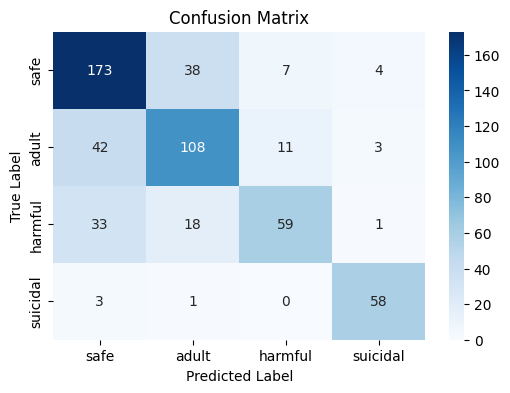

In [27]:
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["safe","adult","harmful","suicidal"], yticklabels=["safe","adult","harmful","suicidal"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()